<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

In [31]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.6.0


In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_utils(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(5, 5))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


## Load and Preprocess the Data

In [33]:
#load train and test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [34]:
#normalize pixel value
X_train = X_train.astype(np.float32)/255.0
X_test = X_test.astype(np.float32)/255.0

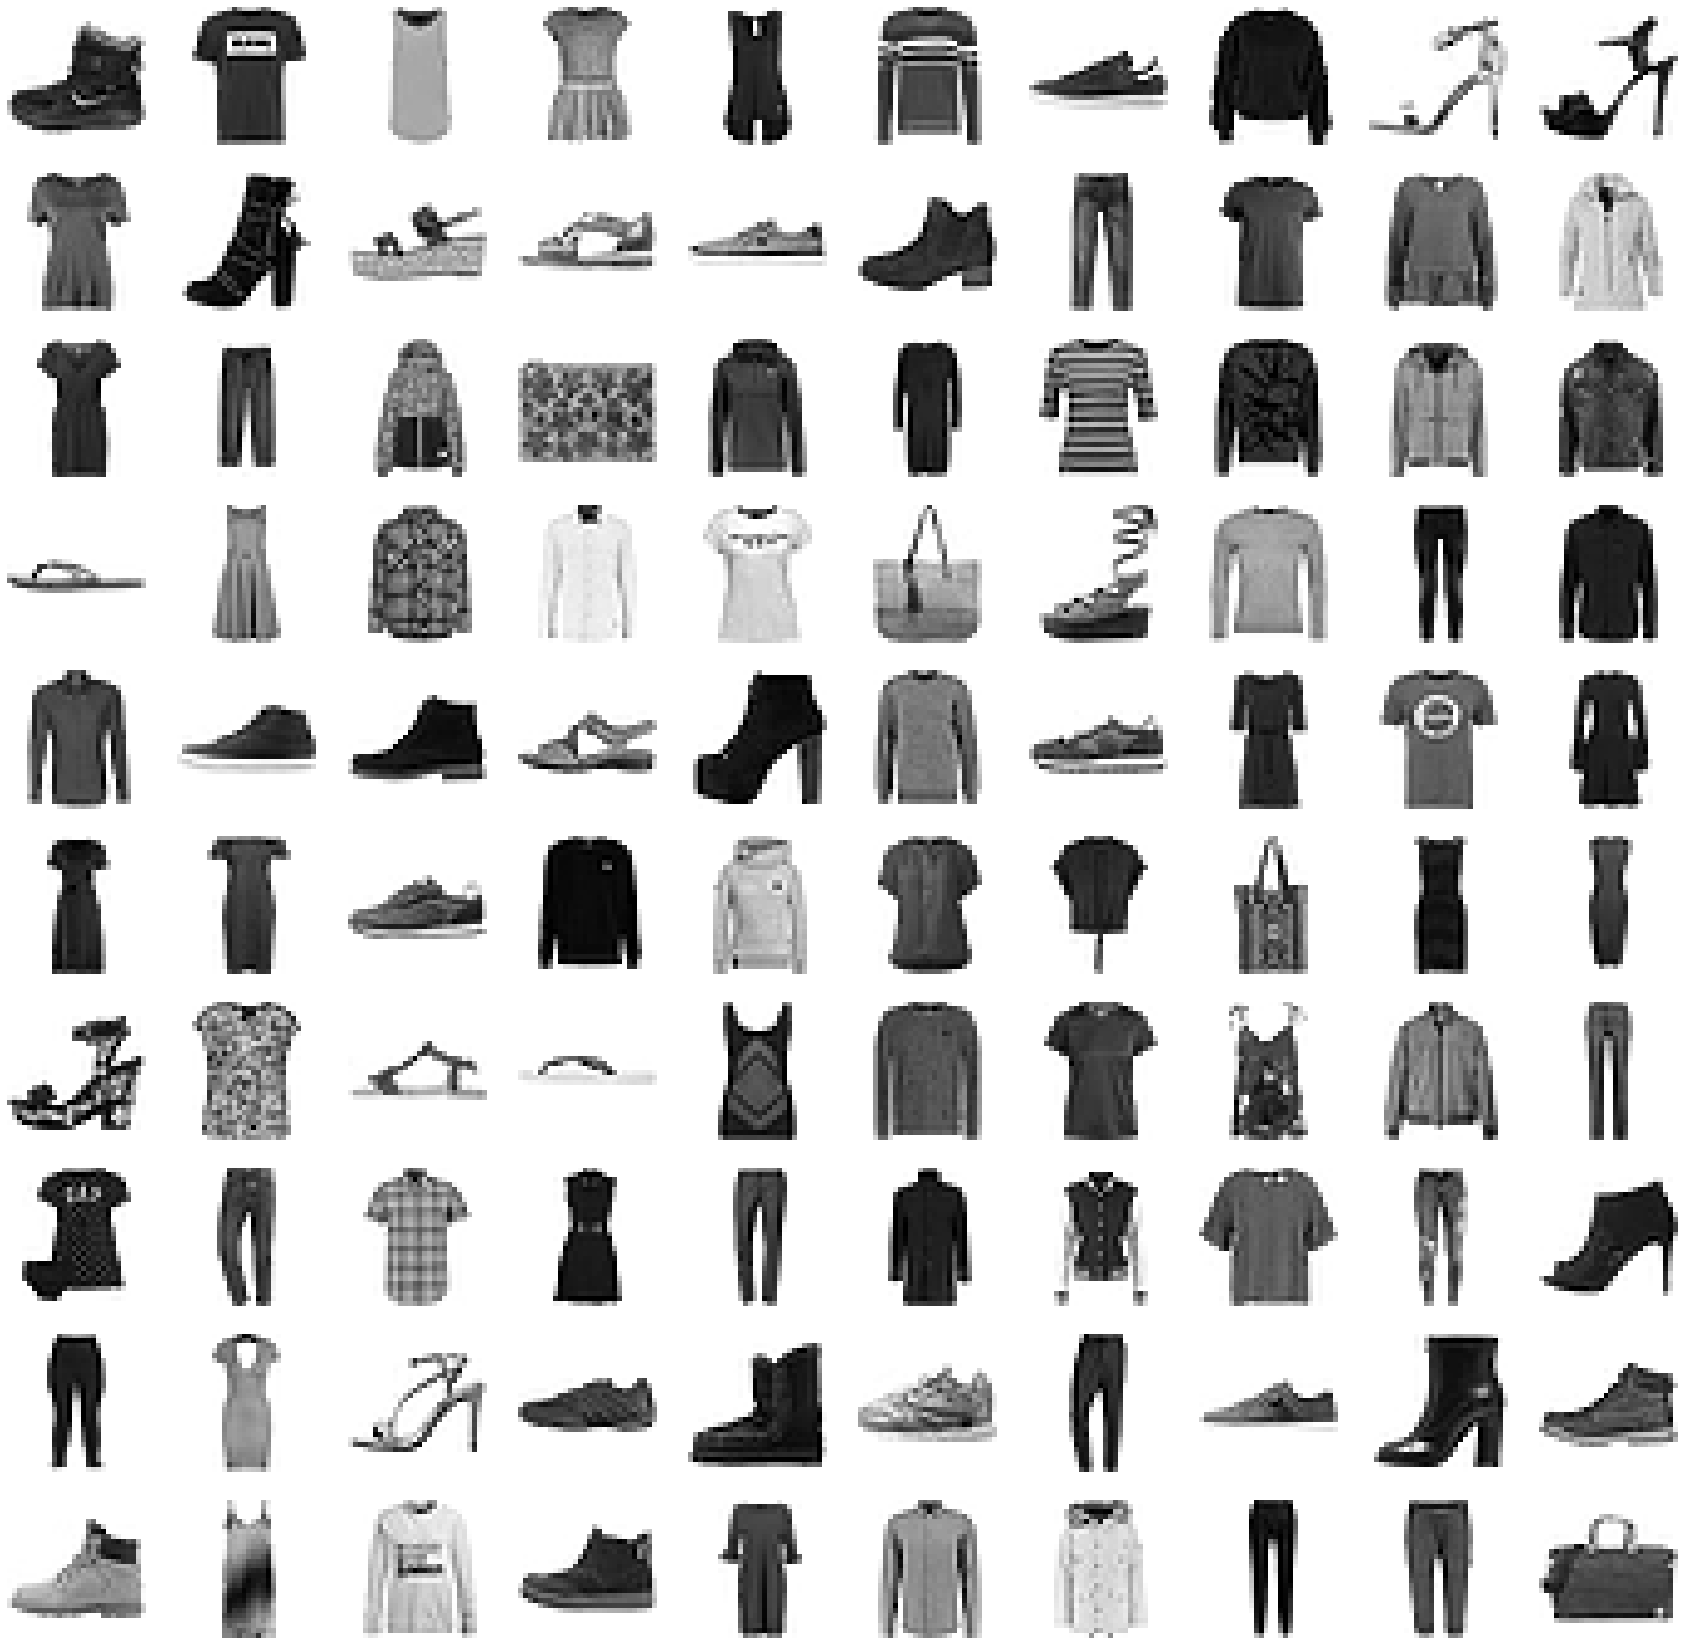

In [35]:
#plot images from the training dataset
plt.figure(figsize=(30, 30))
for i in range(100):
	# define subplot
	plt.subplot(10, 10, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(X_train[i], cmap=plt.cm.binary)
 
#show 
plt.show()

## Create Batches of Training Data

In [36]:
batch_size = 32

#create dataset using X_train
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)

#combines consecutive elements of this dataset into batches
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [37]:
#check shape
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


In [38]:
X_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

## Build the Generator Network for DCGAN

In [39]:
#set number of features
num_features = 100

#create generator
generator = keras.models.Sequential([#foundation 7x7 image
                                     keras.layers.Dense(7*7*128, input_shape=[num_features]), #(7*7*128) is number of units
                                     keras.layers.LeakyReLU(alpha=0.2),

                                     #reshape for additional channel
                                     keras.layers.Reshape([7, 7, 128]),
                                     
                                     #upsample to 14x14
                                     keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
                                     keras.layers.LeakyReLU(alpha=0.2),
                                    
                                     #upsample to 28x28
                                     keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',), #num units, filter, stride | selu is recommended for DCGAN
                                     keras.layers.LeakyReLU(alpha=0.2),

                                     #output
                                     keras.layers.Conv2DTranspose(1, 7, padding='same', activation='tanh')])

In [40]:
#model summary
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 128)      

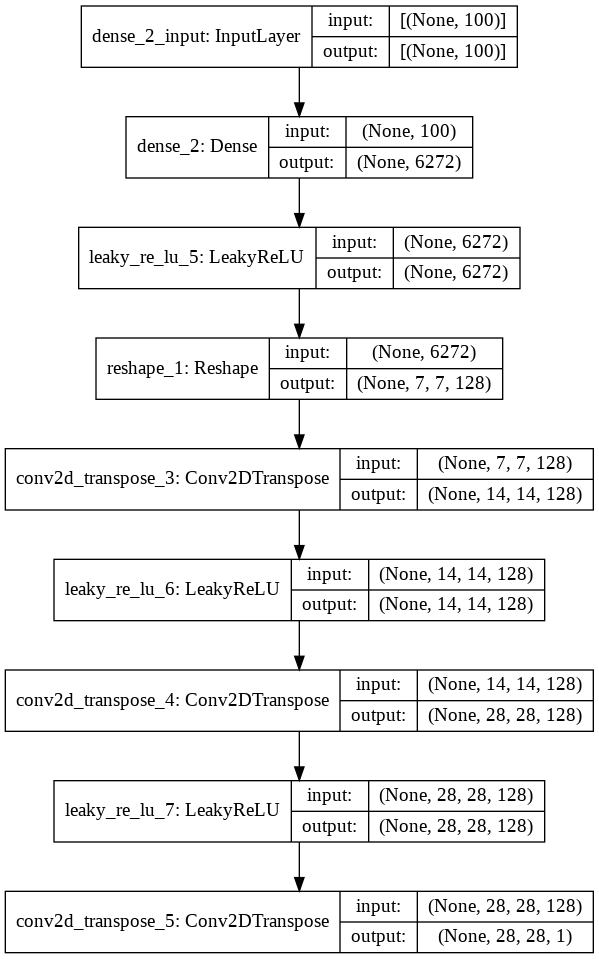

In [41]:
from keras.utils.vis_utils import plot_model

#plot
plot_model(generator, to_file = 'generator_plot.png', show_shapes = True, show_layer_names = True)

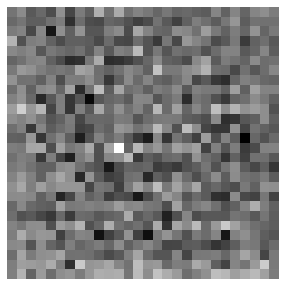

In [42]:
#create vector of random noise to pass through the generator to see what the output is without the network having been trained
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)

#plot image
plot_utils(generated_image, 1)

## Build the Discriminator Network for DCGAN

In [43]:
#create discriminator (which is a CNN-based image classifier)
discriminator = keras.models.Sequential([keras.layers.Conv2D(128, (3,3), strides=(2,2), input_shape=[28, 28, 1]),
                                         keras.layers.LeakyReLU(alpha=0.2),

                                         keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'),
                                         keras.layers.LeakyReLU(alpha=0.2),

                                         keras.layers.Flatten(),
                                         keras.layers.Dropout(0.5),
                                         keras.layers.Dense(1, activation='sigmoid')])

In [44]:
#model summary
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 13, 13, 128)       1280      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

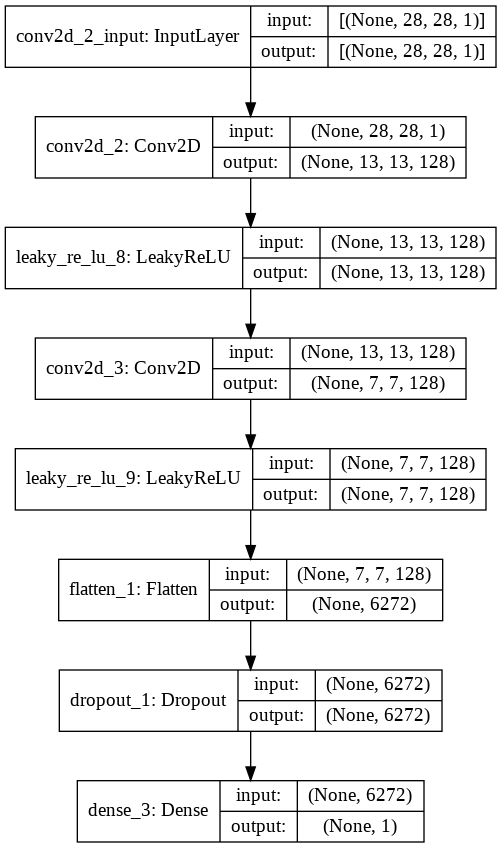

In [45]:
#plot
plot_model(discriminator, to_file = 'discriminator_plot.png', show_shapes = True, show_layer_names = True)

In [46]:
#compile
discriminator.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

#specify that discriminator is not trainable as default because we only want to train generator at first
discriminator.trainable = False

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [47]:
#create noise
decision = discriminator(generated_image)

#if closer to 0 ~ fake, if closer to 1 ~ real
print(decision)

tf.Tensor([[0.5007632]], shape=(1, 1), dtype=float32)


## Define Training Procedure

In [48]:
#create seed image
seed = tf.random.normal(shape=[batch_size,  100])

In [49]:
#define training procedure
from tqdm import tqdm

def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):

    generator, discriminator = gan.layers

    #enumerate epochs
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))

        for X_batch in dataset:

            #generate input noise
            noise = tf.random.normal(shape=[batch_size, num_features])

            #use generator to generate 'fake' images
            generated_images = generator(noise)
            
            #combine 'real' images from X_batch and 'fake' images from generator
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            
            #add noise to labels
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            #train the discriminator separatedly from DCGAN to classify images
            discriminator.trainable = True
            
            #update discriminator model weights
            discriminator.train_on_batch(X_fake_and_real, y1)

            #generate input noise
            noise = tf.random.normal(shape=[batch_size, num_features])
            
            #add noise to labels
            y2 = tf.constant([[1.]] * batch_size)
            
            #after the discriminator is done training, stop updating discriminator's weights
            discriminator.trainable = False
            
            #update the generator via the discriminator's error
            gan.train_on_batch(noise, y2)

        #produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    #display output
    display.clear_output(wait=True)

    #save
    generate_and_save_images(generator, epochs, seed)

In [50]:
#source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
#to create gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train DCGAN

In [51]:
#reshape and scaling
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [52]:
X_train_dcgan.shape

(60000, 28, 28, 1)

In [53]:
#X_train_dcgan

In [54]:
#create batches and shuffle from fashion mnist
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [55]:
#create DCGAN
gan = keras.models.Sequential([generator, discriminator])

#compile DCGAN
gan.compile(loss='binary_crossentropy',
            optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
            metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [56]:
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 155137    
Total params: 1,319,426
Trainable params: 1,164,289
Non-trainable params: 155,137
_________________________________________________________________


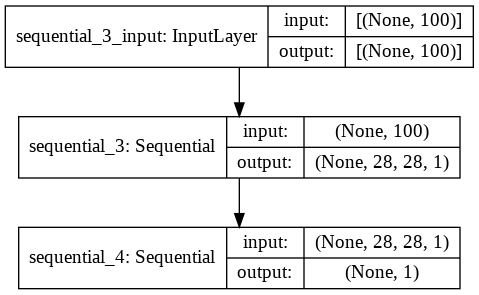

In [57]:
#plot
plot_model(gan, to_file = 'dcgan_plot.png', show_shapes = True, show_layer_names = True)

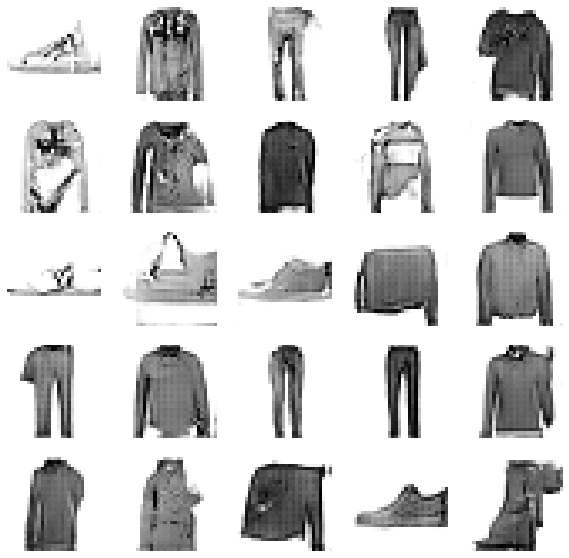

CPU times: user 1h 7min 24s, sys: 3min 36s, total: 1h 11min
Wall time: 1h 15min 7s


In [58]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=100)

## Generate Synthetic Images with DCGAN

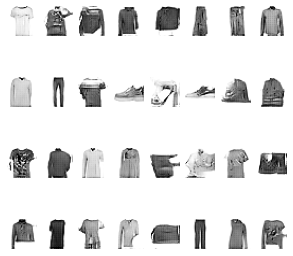

In [59]:
#pass noise into trained generator
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils(generated_images, 8)

In [60]:
#source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)

ValueError: ignored